## Task 1: EDA & Preprocessing

#### Step 1: Load & Filter Complaint Dataset

In [14]:
import pandas as pd
import re


df = pd.read_csv("C:/Users/TadeleBizuye/OneDrive - esxethiopia/Desktop/AI/complaints.csv") 

# Filter only the 5 target products
target_products = ['Credit card', 'Personal loan', 'Buy Now, Pay Later', 'Savings account', 'Money transfers']
df = df[df['Product'].isin(target_products)]

# Drop complaints with empty narratives
df = df[df['Consumer complaint narrative'].notna() & df['Consumer complaint narrative'].str.strip().astype(bool)]

### Step 2: Clean the Text

In [15]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

df["cleaned_narrative"] = df["Consumer complaint narrative"].apply(clean_text)

### Step 3: Save the Cleaned Data

In [16]:
df.to_csv("C:/Users/TadeleBizuye/OneDrive - esxethiopia/Desktop/AI/complaints.csv", index=False)

### Step 4: Perform EDA (Optional Visuals)

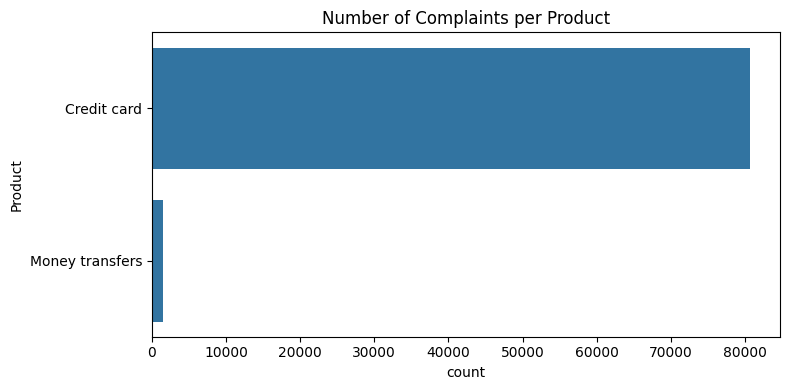

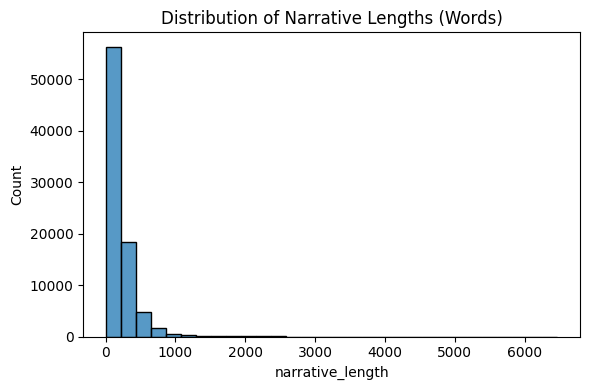

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

# Product Distribution
plt.figure(figsize=(8, 4))
sns.countplot(data=df, y="Product", order=df['Product'].value_counts().index)
plt.title("Number of Complaints per Product")
plt.tight_layout()
plt.show()

# Length of Complaint Narratives
df["narrative_length"] = df["cleaned_narrative"].apply(lambda x: len(x.split()))
plt.figure(figsize=(6, 4))
sns.histplot(df["narrative_length"], bins=30)
plt.title("Distribution of Narrative Lengths (Words)")
plt.tight_layout()
plt.show()

## Task 2: Chunking, Embedding, and Vector Indexing

### Step 1: Chunking

In [18]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(chunk_size=200, chunk_overlap=40)

documents = []
metadatas = []

for idx, row in df.iterrows():
    chunks = text_splitter.split_text(row["cleaned_narrative"])
    for chunk in chunks:
        documents.append(chunk)
        metadatas.append({
            "product": row["Product"],
            "complaint_id": row["Complaint ID"] if "Complaint ID" in row else idx
        })

### Step 2: Generate Embeddings

In [ ]:
import sys
sys.path.append(r"C:\Users\TadeleBizuye\AppData\Roaming\Python\Python312\site-packages")



In [24]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer('all-MiniLM-L6-v2')  # Small & efficient semantic model
embeddings = model.encode(documents, show_progress_bar=True)

ValueError: Your currently installed version of Keras is Keras 3, but this is not yet supported in Transformers. Please install the backwards-compatible tf-keras package with `pip install tf-keras`.

### Step 3: Store Embeddings in FAISS Index

In [ ]:
import faiss
import numpy as np
import os

dimension = embeddings.shape[1]
index = faiss.IndexFlatL2(dimension)
index.add(np.array(embeddings))

# Save FAISS index
os.makedirs("vector_store", exist_ok=True)
faiss.write_index(index, "vector_store/complaints_index.faiss")

# Save metadata
metadata_df = pd.DataFrame(metadatas)
metadata_df.to_csv("vector_store/complaint_metadata.csv", index=False)
